In [40]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [ ]:
from typing import Callable, List, Self
import numpy as np
from node import Node
from transition import Transition
from reward import Reward

# 数値文字列を状態として持つNode
class NumberNode(Node):
    def __init__(self, number: str, parent=None, last_action: int=None, last_prob=1.0):
        self.number = number
        super().__init__(parent=parent, last_prob=last_prob, last_action=last_action)

    def is_terminal(self) -> bool:
        return False
    
    def has_reward(self) -> bool:
        if self.number == "" or self.number.startswith("0"):
            return False
        else:
            return True
    
    def key(self) -> str:
        return self.number
    
    def node_from_key(cls, key: str) -> Self:
        return NumberNode(key)

# 先頭桁に0~9をランダムに追加する変換
class NumberTransition(Transition):
    def transitions_with_probs(self, node: NumberNode) -> list[tuple[int, Node, float]]:
        transitions = []
        for i in range(10):
            next_number = str(i) + node.number
            action = i
            prob = 1 / 10
            next_node = NumberNode(number=next_number, parent=node, last_action=action, last_prob=prob)
            transitions.append((action, next_node, prob))
        return transitions

# 5で割り切れる回数が多く、桁数が少ないほど大きくなるReward    
class NumberReward(Reward):
    def __init__(self, scale: float=1.0):
        self.scale = scale    

    def objective_functions(self) -> List[Callable[[NumberNode], float]]:
        def five_factor_count(node: Node) -> float:
            n = int(node.number)
            count = 0
            while n % 5 == 0 and n > 0:
                n //= 5
                count += 1
            return count
        
        def length(node: Node) -> float:
            return len(node.number)
        
        return [five_factor_count, length]
    
    def reward_from_objective_values(self, objective_values: List[float]) -> float:
        two_factor_count = objective_values[0]
        length = objective_values[1]
        return np.tanh(two_factor_count / length / self.scale)

In [83]:
from generator import MCTS
from policy import UCB1

root = NumberNode("")
transition = NumberTransition()
reward = NumberReward(scale=1.0)

policy = UCB1(c=0.01, best_rate=0.5)
generator = MCTS(root=root, transition=transition, reward=reward, policy=policy, filters=None, info_interval=50)

generator.generate(max_generations=1000)

Starting generation...
<best reward updated> order: 1, time: 0.00, reward: 0.0000, node: 66
<best reward updated> order: 7, time: 0.00, reward: 0.4621, node: 85
<best reward updated> order: 16, time: 0.00, reward: 0.5828, node: 300
<best reward updated> order: 27, time: 0.00, reward: 0.6351, node: 7250
<best reward updated> order: 36, time: 0.01, reward: 0.6640, node: 91250
<best reward updated> order: 48, time: 0.01, reward: 0.6823, node: 831250
generated: 50, time: 0.01, average over 50: 0.4013
<best reward updated> order: 63, time: 0.01, reward: 0.6948, node: 8531250
<best reward updated> order: 82, time: 0.01, reward: 0.7039, node: 93281250
generated: 100, time: 0.02, average over 50: 0.6304
<best reward updated> order: 102, time: 0.02, reward: 0.7108, node: 288281250
<best reward updated> order: 112, time: 0.02, reward: 0.7163, node: 4738281250
<best reward updated> order: 123, time: 0.02, reward: 0.7616, node: 5488281250
<best reward updated> order: 148, time: 0.03, reward: 0.792

number of generated nodes: 1000
valid rate: 1.0
unique rate: 1.0
node_per_sec: 2558.6272989527715
best_reward: 0.79205527771202
average_reward: 0.7013375366329713


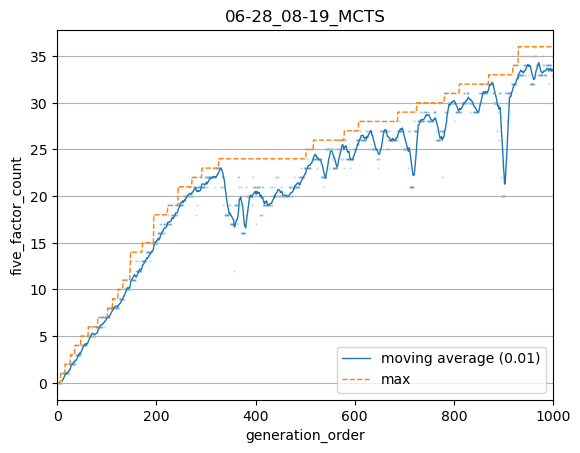

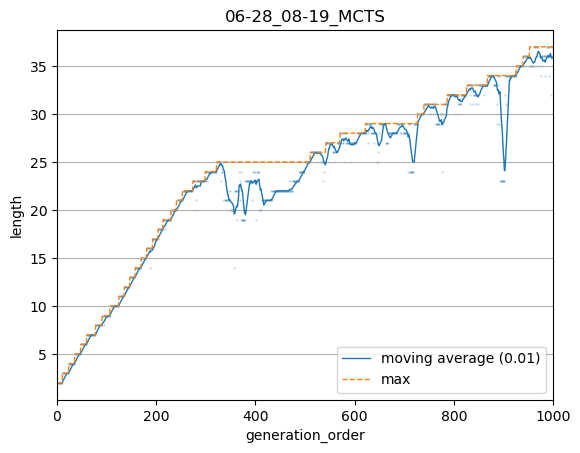

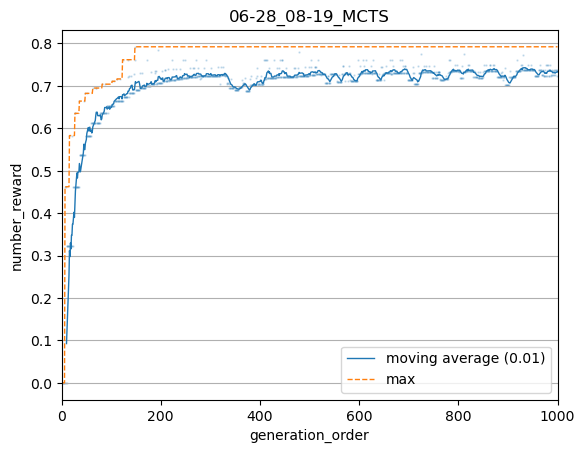

In [84]:
generator.analyze()
generator.plot(moving_average_window=0.01)